In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from config import PROCESSED_FOLDER_PATH
from chesswinnerprediction.models.naive_model import estimate_prediction_by_elo
from chesswinnerprediction.baseline.utils import estimate_baseline_model, get_x_and_y, get_class_weights
from chesswinnerprediction.constants import DRAW_STR

In [3]:
data_path = os.path.join(PROCESSED_FOLDER_PATH, "lichess_db_standard_rated_2017-03.csv")

original_df = pd.read_csv(data_path)

In [4]:
BASELINE_COLUMNS = [
    "Result",  
    "EloDiff",
    "WhiteElo", 
    "BlackElo", 
    "Event",
    "BaseTime", 
    "IncrementTime", 
    "ZeroIncrementTime"
]

In [5]:
df = original_df[BASELINE_COLUMNS].copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122217 entries, 0 to 122216
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Result             122217 non-null  object
 1   EloDiff            122217 non-null  int64 
 2   WhiteElo           122217 non-null  int64 
 3   BlackElo           122217 non-null  int64 
 4   Event              122217 non-null  object
 5   BaseTime           122217 non-null  int64 
 6   IncrementTime      122217 non-null  int64 
 7   ZeroIncrementTime  122217 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 7.5+ MB


In [7]:
df.head()

,Result,EloDiff,WhiteElo,BlackElo,Event,BaseTime,IncrementTime,ZeroIncrementTime
0,0-1,-233,1234,1467,Rated Blitz game,300,0,1
1,1-0,28,1988,1960,Rated Blitz game,180,0,1
2,1-0,-9,1891,1900,Rated Blitz game,300,0,1
3,1-0,-22,1342,1364,Rated Classical game,600,0,1
4,0-1,-55,1575,1630,Rated Classical game,900,15,0


In [8]:
df = pd.get_dummies(df, columns=["Event"], dtype=np.int8, prefix="", prefix_sep="")

In [9]:
columns_to_scale = ["WhiteElo", "BlackElo", "EloDiff", "BaseTime", "IncrementTime"]

scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

## Naive Prediction
Let's implement a naive prediction model. This model will predict that the player with the highest rating will win the game. I will attempt to predict the result both with and without considering draws.


In [10]:
def apply_naive_prediction(count_draws):
    accuracy = estimate_prediction_by_elo(df["WhiteElo"], df["BlackElo"], df["Result"], count_draws=count_draws)
    print(f"\nCount draws: {count_draws}")
    print(f"\tAccuracy: {round(accuracy * 100, 2)}%")

In [11]:
print("\t\tNaive prediction (player with the highest rating wins)")
apply_naive_prediction(count_draws=False)
apply_naive_prediction(count_draws=True)

		Naive prediction (player with the highest rating wins)

Count draws: False
	Accuracy: 60.24%

Count draws: True
	Accuracy: 58.68%


As you can see, neglecting draws results in only a slight decrease in accuracy (-1.5%)

## Class Imbalance
Let's compute class weights for the logistic regression model

In [12]:
scip_draws_class_weights = get_class_weights(df["Result"][df["Result"] != DRAW_STR], verbose=True)

Class weights:
	0-1: 1.0183303395774528
	1-0: 0.9823178982804713


In [13]:
include_draws_class_weights = get_class_weights(df["Result"], verbose=True)

Class weights:
	0-1: 0.6969292618253358
	1-0: 0.6722829136275125
	1/2-1/2: 12.875790139064476


## Logistic Regression Model
Let's implement a logistic regression model to predict the outcome of the game. 

I will try to predict the result both with and without considering draws.


In [14]:
def apply_logistic_regression(predict_draws, data, penalty="l1", solver="saga", max_iter=1500):
    X, y = get_x_and_y(data, predict_draws=predict_draws)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = LogisticRegression(
        class_weight=get_class_weights(y), 
        max_iter=max_iter, 
        penalty=penalty, 
        solver=solver
    )
    model.fit(X_train, y_train)
    
    estimate_baseline_model(model, X_test, y_test, feature_importance=np.abs(model.coef_[0]))

#### Predicting Without Draws Using L2 Penalties


log loss on test data: 0.6551907466923433

						Classification Report 
              precision    recall  f1-score   support

         0-1       0.59      0.60      0.60      5845
         1-0       0.61      0.60      0.61      6061

    accuracy                           0.60     11906
   macro avg       0.60      0.60      0.60     11906
weighted avg       0.60      0.60      0.60     11906



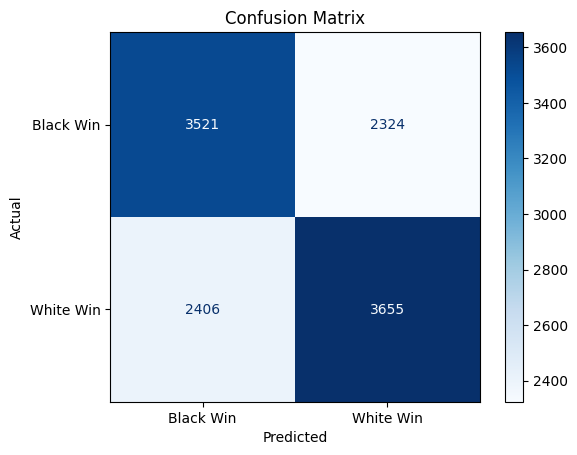

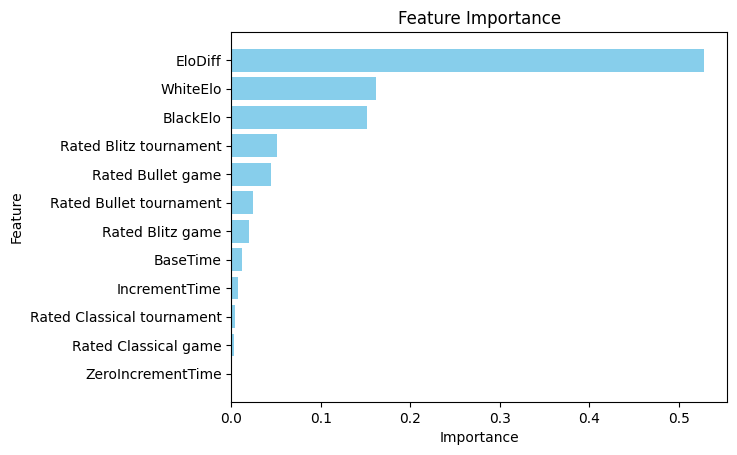

In [15]:
apply_logistic_regression(predict_draws=False, data=df, penalty="l2")

#### Predicting Without Draws Using L2 Penalties

log loss on test data: 0.6551884064771286

						Classification Report 
              precision    recall  f1-score   support

         0-1       0.59      0.60      0.60      5845
         1-0       0.61      0.60      0.61      6061

    accuracy                           0.60     11906
   macro avg       0.60      0.60      0.60     11906
weighted avg       0.60      0.60      0.60     11906



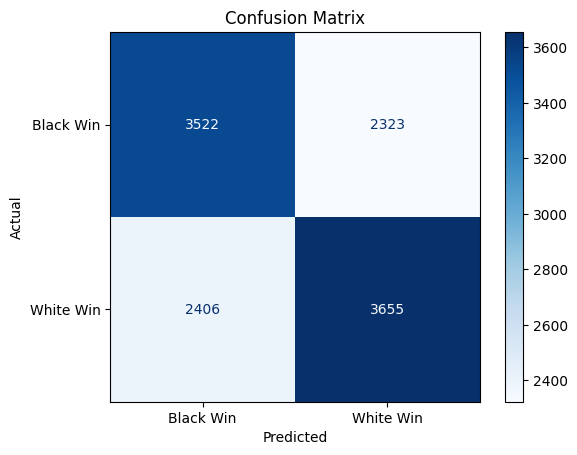

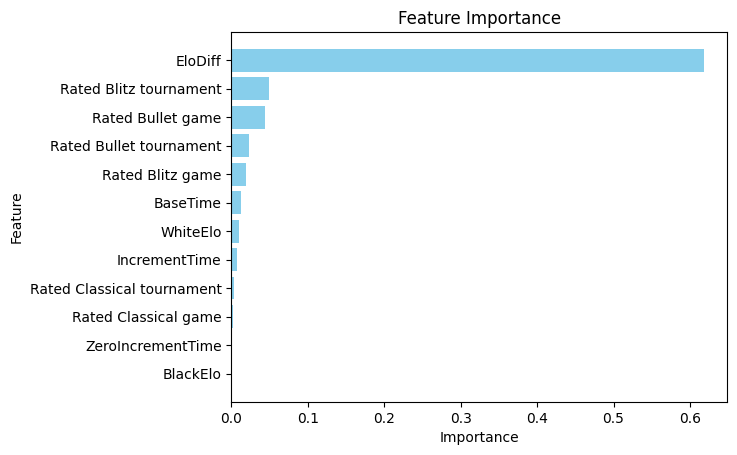

In [16]:
apply_logistic_regression(predict_draws=False, data=df, penalty="l1")

Accuracy is close to naive prediction (around 60%). The most important feature is the difference in ELO, which is especially evident when using L1 penalty.


#### Predicting With Draws Using L2 Penalties

log loss on test data: 1.035929631983377

						Classification Report 
              precision    recall  f1-score   support

         0-1       0.61      0.42      0.50      5972
         1-0       0.60      0.42      0.50      5934
     1/2-1/2       0.04      0.49      0.07       316

    accuracy                           0.42     12222
   macro avg       0.42      0.44      0.36     12222
weighted avg       0.59      0.42      0.49     12222



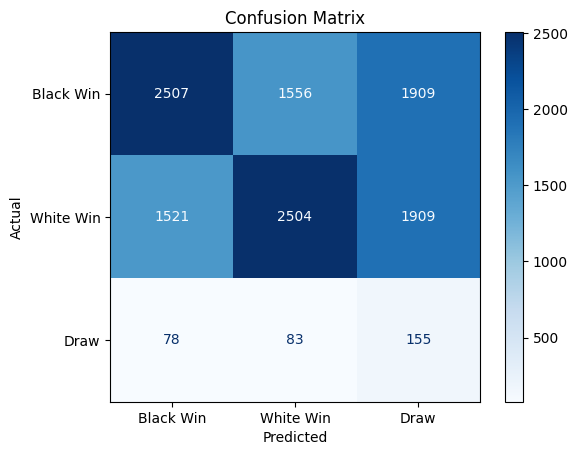

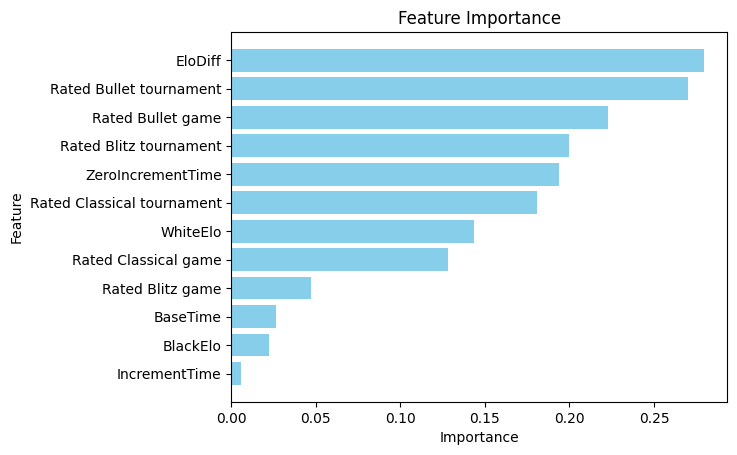

In [17]:
apply_logistic_regression(predict_draws=True, data=df, penalty="l2")

Of course, predicting draws has negatively impacted the overall picture: both recall and F1 score have dropped significantly. Draws have poor precision and F1 score, but quite decent recall.

It's also interesting to note, that the feature importance chart looks completely different here.


log loss on test data: 1.035925863414159

						Classification Report 
              precision    recall  f1-score   support

         0-1       0.61      0.42      0.50      5972
         1-0       0.60      0.42      0.50      5934
     1/2-1/2       0.04      0.49      0.07       316

    accuracy                           0.42     12222
   macro avg       0.42      0.44      0.36     12222
weighted avg       0.59      0.42      0.49     12222



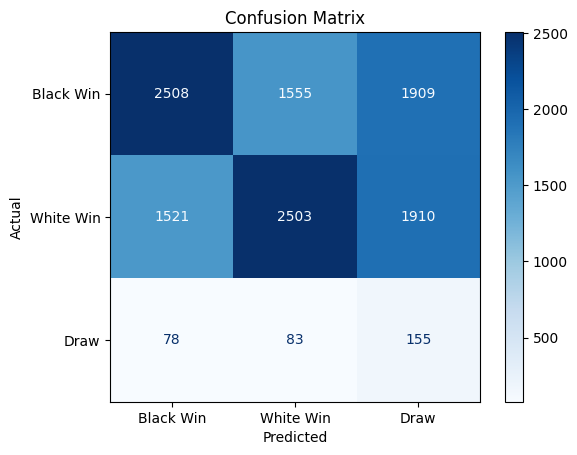

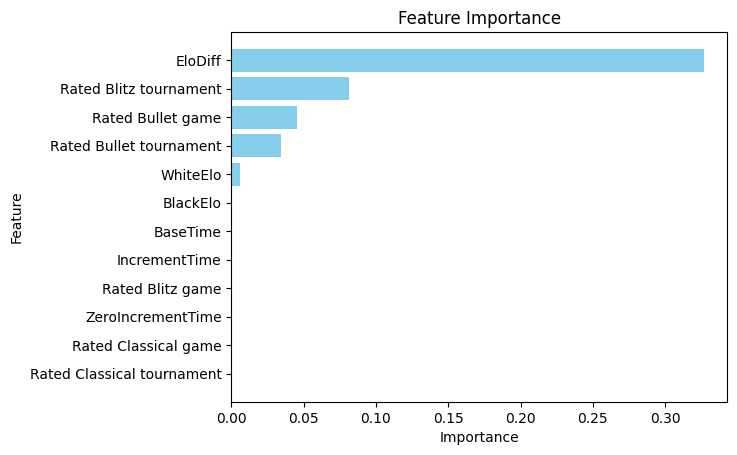

In [18]:
apply_logistic_regression(predict_draws=True, data=df, penalty="l1")

The L1 penalty moved EloDiff to the top position again. Interestingly, this did not affect the model's results. Both models have identical precision, recall, and F1 scores.
